In [1]:
# pip install diffusers[torch]


In [1]:
import os
import cv2
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from diffusers import StableDiffusionImg2ImgPipeline
from diffusers import UNet2DConditionModel, DDPMScheduler
from torch.utils.data import DataLoader
from torchvision import transforms
from datasets import load_dataset
import torch
from PIL import Image


In [2]:
# Step 1: Load Pre-trained Model Components
model_name = "runwayml/stable-diffusion-v1-5"
# Setting up device
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Training on: ",device)

Training on:  cuda


In [16]:


# unet = UNet2DConditionModel.from_pretrained(model_name, subfolder="unet")
# vae = StableDiffusionImg2ImgPipeline.from_pretrained(model_name, subfolder="vae")
# text_encoder = StableDiffusionImg2ImgPipeline.from_pretrained(model_name, subfolder="text_encoder")
pipeline = StableDiffusionImg2ImgPipeline.from_pretrained(model_name, safety_checker = None, torch_dtype=torch.float16).to(device)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [4]:
def load_data():
    hernia_path_train = 'Hernia_tr(154)'

    x1_tr = []
    y1_tr = []


    for filename in os.listdir(hernia_path_train):
        img = cv2.imread(os.path.join(hernia_path_train, filename), 0)
        if img is not None:
            img = (img / 255.0).astype(np.float32)
            # store loaded image
            assert (img.shape == (128, 128))
            x1_tr.append(img)
            y1_tr.append(1)

    return (x1_tr, y1_tr)

In [5]:
(x1, y1) = load_data();
x = np.array(x1)
y = np.array(y1)
print("Data Loaded: Shape of x: ", x.shape, "Shape of y: ", y.shape)
x_train = torch.Tensor(x)  # transform to torch tensor
y_train = torch.Tensor(y)

train_dataset = TensorDataset(x_train, y_train)  # create your datset
train_dataloader = DataLoader(train_dataset, batch_size=1)  # create your dataloader

Data Loaded: Shape of x:  (154, 128, 128) Shape of y:  (154,)


In [6]:
from tqdm import tqdm

In [7]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
# Step 3: Define Optimizer and Scheduler
optimizer = torch.optim.AdamW(pipeline.unet.parameters(), lr=5e-6)
from diffusers import StableDiffusionImg2ImgPipeline, DDIMScheduler

# pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
#     "runwayml/stable-diffusion-v1-5",
#     scheduler=DDIMScheduler.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="scheduler")
# )


# Step 4: Fine-Tuning Loop
num_epochs = 3
unet = pipeline.unet
unet.to(device)

for epoch in tqdm(range(num_epochs)):
    for images in train_dataloader:
        prompts = []
        
        images = images[0].reshape(-1, 1, 128, 128).to(device)
        batch_size = images.size(0)

        for i in range(batch_size):
            prompts.append("Hernia")

        
        # Generate text embeddings
        tokenizer = pipeline.tokenizer
        text_encoder = pipeline.text_encoder
        inputs = tokenizer(prompts, padding="max_length", return_tensors="pt", max_length=tokenizer.model_max_length).to(device)
        text_embeddings = text_encoder(input_ids=inputs.input_ids)[0]
            
        # Forward pass
        noise = torch.randn_like(images).to(device)
        noisy_images = images + noise
        noisy_images = noisy_images.repeat(1, 4, 1, 1)
        
        noisy_images = noisy_images.float()
        text_embeddings = text_embeddings.float()
        unet = unet.float()
        timesteps = torch.randint(0, pipeline.scheduler.config.num_train_timesteps, (batch_size,), device=device).long()

        predicted_noise = pipeline.unet(noisy_images,timesteps, text_embeddings)["sample"]
        
        # Compute loss
        loss = torch.nn.functional.mse_loss(predicted_noise, noise.repeat(1, 4, 1, 1))
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del noisy_images, predicted_noise, noise
        torch.cuda.empty_cache()
        # print("hi")

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}")

# Save Fine-Tuned Model
unet.save_pretrained("./fine_tuned_model")

 33%|███▎      | 1/3 [05:35<11:11, 336.00s/it]

Epoch 1/3, Loss: 0.008061926811933517


 67%|██████▋   | 2/3 [11:09<05:34, 334.80s/it]

Epoch 2/3, Loss: 0.008168816566467285


100%|██████████| 3/3 [16:44<00:00, 334.79s/it]

Epoch 3/3, Loss: 0.007373495493084192


In [7]:
device

'cuda'

In [17]:
pipeline.unet = UNet2DConditionModel.from_pretrained("./fine_tuned_model").to(device).to(torch.float16)

In [50]:
from PIL import Image
from torchvision import transforms

init_image = Image.open("hernia.png").convert("RGB")
init_image = init_image.resize((768, 512))
transform = transforms.ToTensor()
init_image_tensor = transform(init_image).unsqueeze(0) 
init_image_tensor = init_image_tensor.to(torch.float16)

In [19]:
pipeline.text_encoder = pipeline.text_encoder.to(torch.float16)
# pipeline.unet =  pipeline.unet.to(torch.float16)

  0%|          | 0/15 [00:00<?, ?it/s]

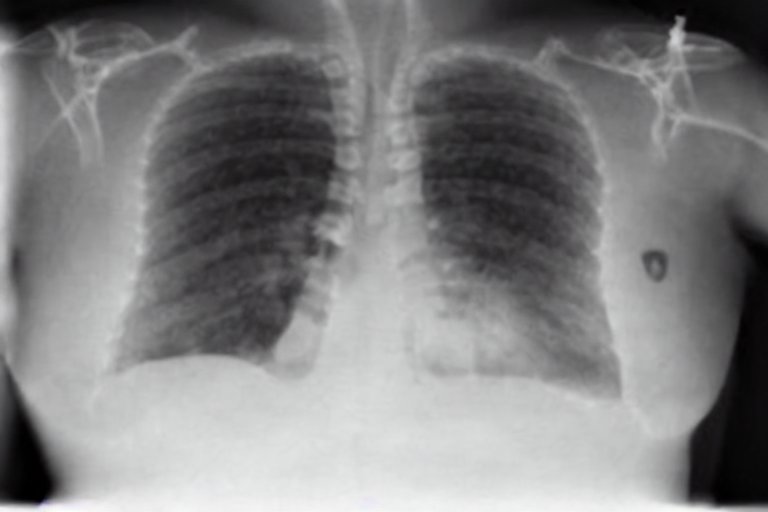

In [51]:
# Generate an image
output_image = pipeline(prompt="xray image of hernia patient", image=init_image_tensor, strength=0.3).images[0]
output_image

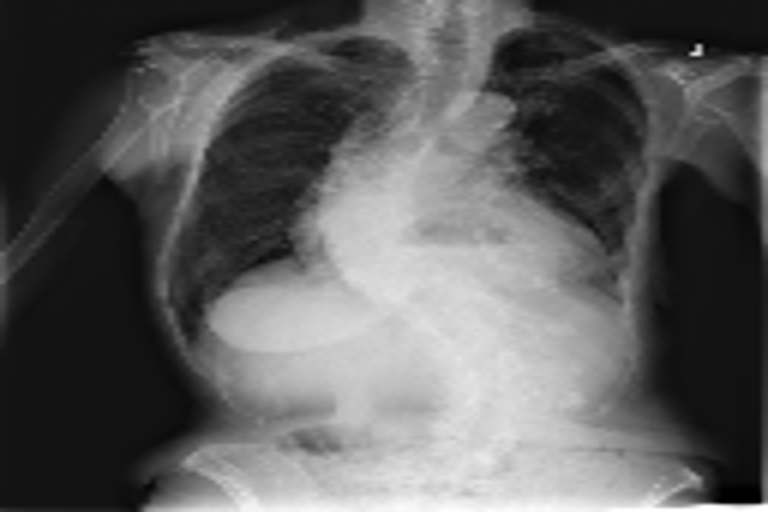

In [48]:
init_image

In [31]:
type(output_image)

PIL.Image.Image

In [34]:
output_image.save("Generated images/img1.png","PNG")

In [45]:
for filename in os.listdir("Hernia_tr(154)"):
    init_image = Image.open(os.path.join("Hernia_tr(154)", filename)).convert("RGB")
    init_image = init_image.resize((768, 512))
    transform = transforms.ToTensor()
    init_image_tensor = transform(init_image).unsqueeze(0) 
    init_image_tensor = init_image_tensor.to(torch.float16)
    output_image = pipeline(prompt="xray image of hernia patient", image=init_image_tensor, strength=0.2).images[0]
    output_image.save("Generated images/"+ filename,"PNG")


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]